In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
import os

# Add the directory to sys.path
module_path = os.path.abspath(os.path.join('..', '/models'))
if module_path not in sys.path:
    sys.path.append(module_path)

from NCF_model import NCF, NCFDataset

In [22]:
def custom_collate_fn(batch):
    users, items, emotions, review_embeddings, ratings = zip(*batch)
    
    users = torch.tensor(users, dtype=torch.long)
    items = torch.tensor(items, dtype=torch.long)
    emotions = torch.tensor(emotions, dtype=torch.long)
    review_embeddings = torch.tensor(review_embeddings, dtype=torch.float)
    ratings = torch.tensor(ratings, dtype=torch.float)
    
    # Move tensors to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    users = users.to(device)
    items = items.to(device)
    emotions = emotions.to(device)
    review_embeddings = review_embeddings.to(device)
    ratings = ratings.to(device)
    
    return users, items, emotions, review_embeddings, ratings

In [23]:
embedding_dim = 32
review_embedding_dim = 100
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Assume we have these functions to load and preprocess data
user_item_interactions, emotion_labels, review_embeddings = load_data()
num_users, num_items, num_emotions = get_data_info(user_item_interactions, emotion_labels)

# Create dataset and dataloader
dataset = NCFDataset(user_item_interactions, emotion_labels, review_embeddings)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)

(575887, 74298)


In [24]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCF(num_users, num_items, num_emotions, 
            embedding_dim=32, 
            review_embedding_dim=100, 
            mlp_dims=[256, 128, 64], 
            dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Load the best model checkpoint
model.load_state_dict(torch.load('../models/NCF_model.pth', map_location=device))

<All keys matched successfully>

In [37]:
from collections import defaultdict

model.eval()
top_k = 10
test_loss = 0.0

# To store top 10 recommendations per user
all_recommendations = defaultdict(list)
emotion_recommendations = defaultdict(list)
actual_items = defaultdict(list)
true_relevance = defaultdict(dict)
true_emotion_relevance = defaultdict(dict)

with torch.no_grad():
    for user, item, emotion, review_emb, rating in test_loader:
        # Generate predictions for all items for each user
        predictions = model(user, item, emotion, review_emb)
        predictions = predictions.cpu().numpy()
        for i in range(len(predictions)):
            if predictions[i] < 0:
                predictions[i] = 0
            elif predictions[i] > 1:
                predictions[i] = 1
        for u, i, e, p, r in zip(user.numpy(), item.numpy(), emotion.numpy(), predictions, rating.numpy()):
            all_recommendations[u].append((i, p))
            emotion_recommendations[u].append((i, p, e))
            true_relevance[u][i] = r
            true_emotion_relevance[u][i] = (r, e)


In [27]:
def dcg_at_k(ranking, relevances, k):
    dcg = 0.0
    for i in range(min(k, len(ranking))):
        item = ranking[i][0]
        relevance = relevances.get(item, 0)
        dcg += (2**relevance - 1) / np.log2(i + 2)
    return dcg

def ndcg_at_k(ranking, relevances, k):
    dcg = dcg_at_k(ranking, relevances, k)
    ideal_ranking = sorted(relevances.items(), key=lambda x: x[1], reverse=True)
    idcg = dcg_at_k(ideal_ranking, relevances, k)
    return dcg / idcg if idcg > 0 else 0

def average_precision(ranking, relevances):
    ap = 0.0
    relevant_count = 0
    num_relevant_items = len(relevances)
    
    if num_relevant_items == 0:
        return 0
    
    for i, (item, _) in enumerate(ranking):
        if relevances.get(item, 0) > 0:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    # Avoid division by zero if there are no relevant items
    return ap / num_relevant_items if num_relevant_items > 0 else 0

# Example usage
k = 10
ndcg_scores = []
ap_scores = []
precisions = []
recalls = []

for user, recommendations in all_recommendations.items():
    sorted_recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:k]
    top_k_items = [item for item, _ in sorted_recommendations]
    relevant_items = set(item for item, rating in true_relevance[user].items())
    true_positives = len(set(top_k_items) & relevant_items)
    precision = true_positives / k
    recall = true_positives / len(relevant_items) if relevant_items else 0
        
    precisions.append(precision)
    recalls.append(recall)
    ndcg = ndcg_at_k(sorted_recommendations, true_relevance[user], k)
    ndcg_scores.append(ndcg)
    ap = average_precision(sorted_recommendations, true_relevance[user])
    ap_scores.append(ap)

print(f"Average Precision@{k}: {np.mean(precisions):.4f}")
print(f"Average Recall@{k}: {np.mean(recalls):.4f}")
mean_ndcg = np.mean(ndcg_scores)
print(f"Mean NDCG@{k}: {mean_ndcg:.4f}")
mean_ap = np.mean(ap_scores)
print(f"Mean Average Precision@{k}: {mean_ap:.4f}")

Average Precision@10: 0.1332
Average Recall@10: 0.9977
Mean NDCG@10: 0.9971
Mean Average Precision@10: 0.9977


In [28]:
true_ratings = []
predicted_ratings = []
for user, recs in all_recommendations.items():
    for item, pred in recs:
        if item in true_relevance[user]:
            true_ratings.append(true_relevance[user][item])
            predicted_ratings.append(pred)

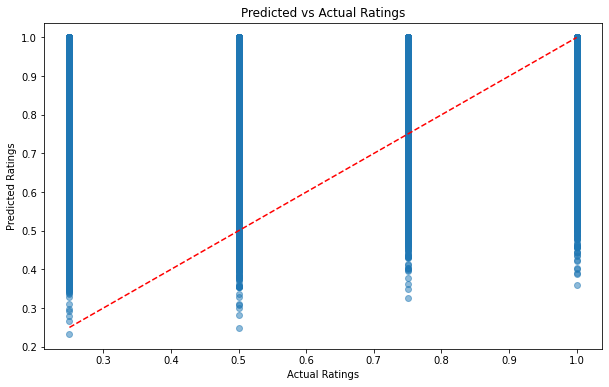

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.scatter(true_ratings, predicted_ratings, alpha=0.5)
plt.plot([min(true_ratings), max(true_ratings)], [min(true_ratings), max(true_ratings)], 'r--')  # Diagonal line for perfect predictions
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

The model might be biased toward predicting high ratings because the majority of the data it sees during training are high ratings. This can lead to a situation where the model struggles to accurately predict lower ratings, which might be less frequent in the dataset.

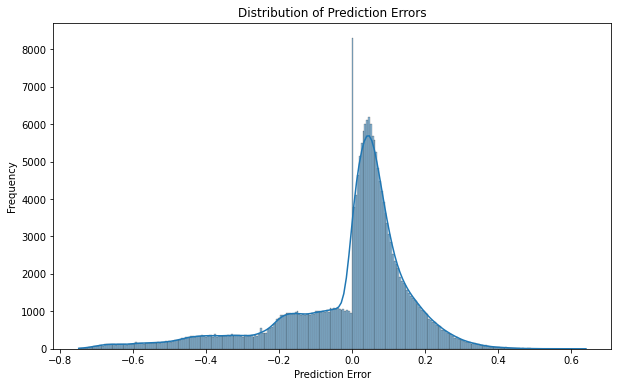

In [30]:
errors = np.array(true_ratings) - np.array(predicted_ratings)
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

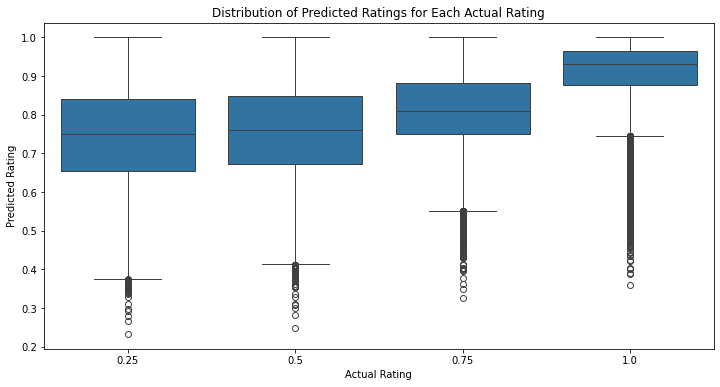

In [31]:
df = pd.DataFrame({'Actual': true_ratings, 'Predicted': predicted_ratings})
plt.figure(figsize=(12, 6))
sns.boxplot(x='Actual', y='Predicted', data=df)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Distribution of Predicted Ratings for Each Actual Rating')
plt.show()

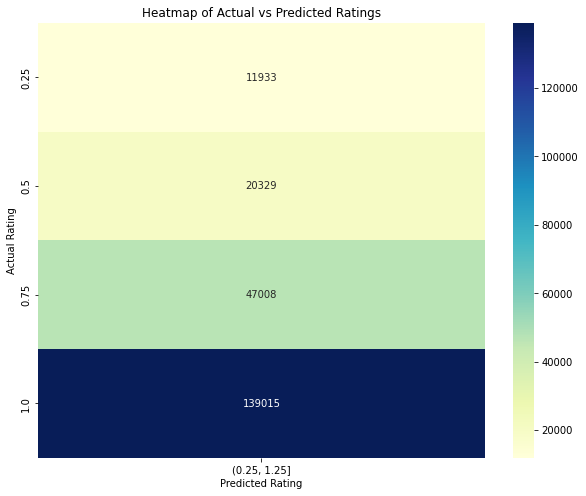

In [32]:
df = pd.DataFrame({'Actual': true_ratings, 'Predicted': predicted_ratings})
df['Predicted'] = pd.cut(df['Predicted'], bins=np.arange(df['Actual'].min(), df['Actual'].max()+1.1, 1))
conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Heatmap of Actual vs Predicted Ratings')
plt.show()

In [33]:
# Count the number of overlaps
overlap_counts = []
for user in all_recommendations.keys():
    recommended_items = set(item for item, _ in all_recommendations[user])
    true_items = set(true_relevance[user].keys())
    overlap = len(recommended_items.intersection(true_items))
    overlap_counts.append(overlap)

<ipython-input-34-0d07596e7190>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Overlap Count', palette='viridis')


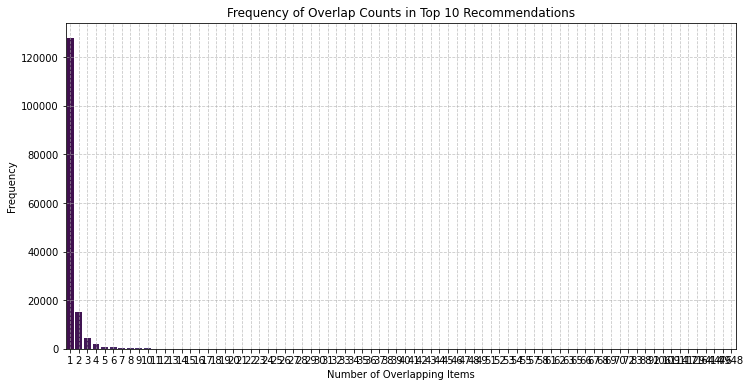

In [34]:
# Convert overlap_counts to DataFrame
df = pd.DataFrame({'Overlap Count': overlap_counts})

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Overlap Count', palette='viridis')
plt.title('Frequency of Overlap Counts in Top 10 Recommendations')
plt.xlabel('Number of Overlapping Items')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Overall conclusions:

Amazon's recommendation system generally provides diverse suggestions, with little overlap between different users' top 10 lists.
There's a strong tendency towards minimal overlap, supporting the idea that the algorithm aims to personalize recommendations.
The rare cases of high overlap might represent niche categories or highly popular books that appear frequently across different recommendations.
The system balances personalization (low overlap) with some consistency (occasional high overlap), possibly to cater to both individual preferences and popular trends.

Recalibrate the Model:

You might want to consider techniques like scaling the ratings, applying a different loss function (e.g., focusing more on the lower ratings), or using methods like label smoothing to encourage the model to be less confident about assigning the highest rating.

Adjust for Imbalance:

Consider balancing the dataset by oversampling lower ratings or undersampling higher ratings during training. Alternatively, you could apply a weighted loss function that penalizes incorrect predictions more heavily for lower ratings, which are underrepresented.

Emotion-Based Filtering:

If you have specific business logic that, for instance, certain emotions should lead to specific types of recommendations (e.g., a user in a "sad" emotional state might prefer different types of items than when they are in a "joyful" state), you could introduce additional filtering or ranking logic based on the predicted emotions.

Personalized Emotional Weighting:

You might consider giving different weights to the influence of emotions on the final prediction. For example, if you find that emotion is particularly important for certain users or items, you could modify the model or post-process the predictions accordingly.

Tuning Strategies:

1) Add label smoothing or different loss function for the model training
2) Add emotion weights in the model 
3) Introduce a weighting mechanism in the loss function that increases or decreases the penalty for errors based on the emotional state. 
4) Concatenate the emotion embeddings with user and item embeddings at multiple points within the MLP and MF components.

### Emotion-Based Recommendations

In [48]:
EMOTION_LABELS = [0,1,2,3,4,5] #['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def get_dominant_emotion(emotion_dist):
    return EMOTION_LABELS[np.argmax(emotion_dist)]

emotion_based_recs = defaultdict(lambda: defaultdict(list))
for user, recs in emotion_recommendations.items():
    for item, pred_rating, emotion_dist in recs:
        dominant_emotion = get_dominant_emotion(emotion_dist)
        emotion_based_recs[user][dominant_emotion].append((item, pred_rating, emotion_dist))

# Sort recommendations for each emotion and keep top N
for user in emotion_based_recs:
    for emotion in emotion_based_recs[user]:
        emotion_based_recs[user][emotion] = sorted(emotion_based_recs[user][emotion], 
                                                    key=lambda x: x[1], reverse=True)[:k]

In [42]:
metrics = defaultdict(lambda: {'precision': [], 'recall': [], 'ndcg': []})

for user, emotion_recs in emotion_based_recs.items():
    for emotion, recs in emotion_recs.items():
        top_k_items = [item for item, _, _ in recs[:k]]
        relevant_items = set(item for item, (rating, item_emotion_dist) in true_emotion_relevance[user].items() 
                            if get_dominant_emotion(item_emotion_dist) == emotion)
        
        # Precision and Recall
        true_positives = len(set(top_k_items) & relevant_items)
        precision = true_positives / len(top_k_items) if top_k_items else 0
        recall = true_positives / len(relevant_items) if relevant_items else 0
        
        metrics[emotion]['precision'].append(precision)
        metrics[emotion]['recall'].append(recall)
        
        # NDCG
        dcg = sum((2**int(item in relevant_items) - 1) / np.log2(i+2) for i, item in enumerate(top_k_items))
        idcg = sum((2**1 - 1) / np.log2(i+2) for i in range(min(len(relevant_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0
        metrics[emotion]['ndcg'].append(ndcg)

for emotion in metrics:
    print(f"Emotion: {emotion}")
    print(f"Average Precision@{k}: {np.mean(metrics[emotion]['precision']):.4f}")
    print(f"Average Recall@{k}: {np.mean(metrics[emotion]['recall']):.4f}")
    print(f"Mean NDCG@{k}: {np.mean(metrics[emotion]['ndcg']):.4f}")

Emotion: 1
Average Precision@10: 1.0000
Average Recall@10: 0.9992
Mean NDCG@10: 1.0000
Emotion: 0
Average Precision@10: 1.0000
Average Recall@10: 0.9985
Mean NDCG@10: 1.0000
Emotion: 3
Average Precision@10: 1.0000
Average Recall@10: 0.9998
Mean NDCG@10: 1.0000
Emotion: 5
Average Precision@10: 1.0000
Average Recall@10: 0.9996
Mean NDCG@10: 1.0000
Emotion: 2
Average Precision@10: 1.0000
Average Recall@10: 0.9996
Mean NDCG@10: 1.0000
Emotion: 4
Average Precision@10: 1.0000
Average Recall@10: 0.9997
Mean NDCG@10: 1.0000


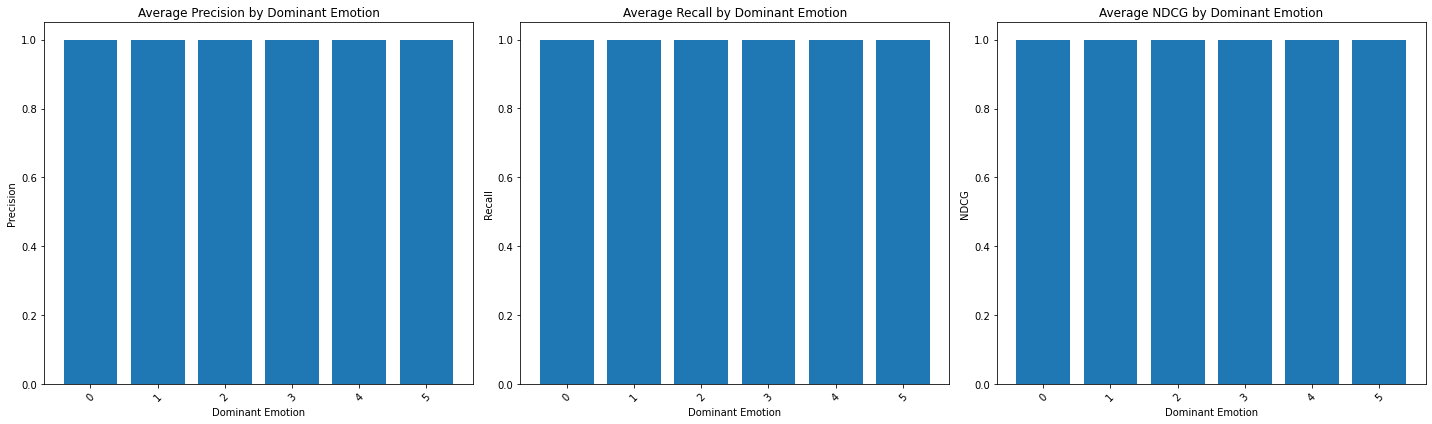

In [43]:
emotions = list(metrics.keys())
precisions = [np.mean(metrics[e]['precision']) for e in emotions]
recalls = [np.mean(metrics[e]['recall']) for e in emotions]
ndcgs = [np.mean(metrics[e]['ndcg']) for e in emotions]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.bar(emotions, precisions)
ax1.set_title('Average Precision by Dominant Emotion')
ax1.set_ylabel('Precision')

ax2.bar(emotions, recalls)
ax2.set_title('Average Recall by Dominant Emotion')
ax2.set_ylabel('Recall')

ax3.bar(emotions, ndcgs)
ax3.set_title('Average NDCG by Dominant Emotion')
ax3.set_ylabel('NDCG')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Dominant Emotion')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

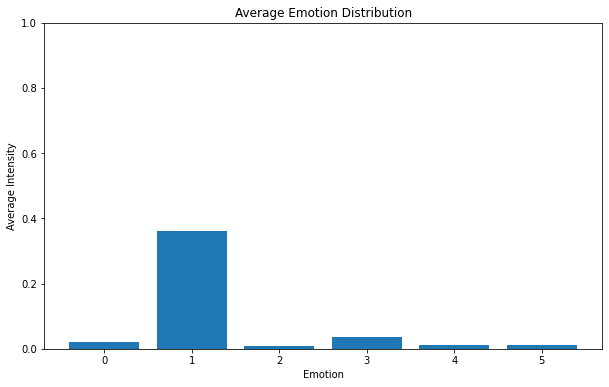

In [45]:
emotion_sums = np.zeros(len(EMOTION_LABELS))
count = 0
for user, items in true_emotion_relevance.items():
    for item, (rating, emotion_dist) in items.items():
        emotion_sums += emotion_dist
        count += 1

average_distribution = emotion_sums / count

plt.figure(figsize=(10, 6))
plt.bar(EMOTION_LABELS, average_distribution)
plt.title('Average Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Average Intensity')
plt.ylim(0, 1)
plt.show()

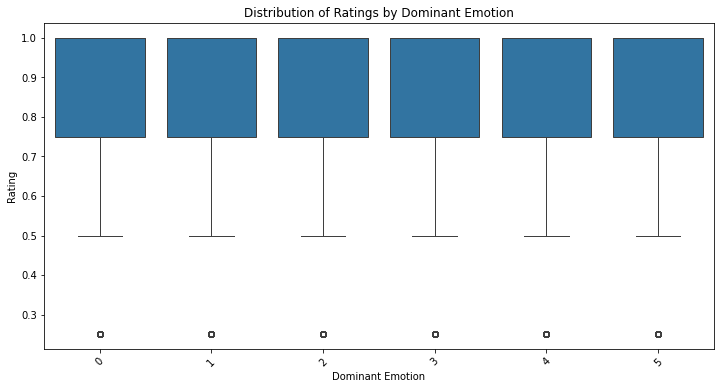

In [46]:
data = []
for user, items in true_emotion_relevance.items():
    for item, (rating, emotion_dist) in items.items():
        dominant_emotion = get_dominant_emotion(emotion_dist)
        data.append({'Dominant Emotion': dominant_emotion, 'Rating': rating})

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Dominant Emotion', y='Rating', data=df)
plt.title('Distribution of Ratings by Dominant Emotion')
plt.xlabel('Dominant Emotion')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()